## Data Science from Scratch

#### Meeting: Nov 9, 2019 @ Cinco Ranch Library, Classroom on 2nd Floor

Reading through and working exercises from the Second Edition of Joel Grus' classic book, Data Science from Scratch: First Principles from Python

### Chapter 17 - Decision Trees

Focus here is on classification trees with the ID3 algorithm. 



### Entropy

Entropy = measure how much information held in given unit

High Entropy => poor encoding, limited corresponding information

Low Entropy => good encoding, capture of corresponding information

In [17]:
import math

def log0 (p: float) -> float:
    return math.log(p, 2) if p != 0 else 0

p = [x/20.0 for x in range(0, 21)]
print(p)
negplogp = [-x * log0(x) for x in p]
print(negplogp)

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
[-0.0, 0.21609640474436814, 0.33219280948873625, 0.4105448391249309, 0.46438561897747244, 0.5, 0.5210896782498619, 0.5301006104904155, 0.5287712379549449, 0.5184013920502726, 0.5, 0.4743730619375358, 0.44217935649972373, 0.4039674448850756, 0.3602012209808308, 0.31127812445913283, 0.2575424759098898, 0.19929546559146952, 0.13680278410054497, 0.07030055237158808, -0.0]


Text(0.5, 1.0, 'Entropy')

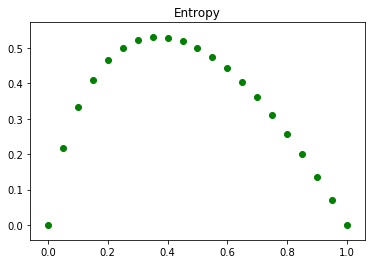

In [18]:
import matplotlib.pyplot as plt
plt.scatter(p, negplogp, color='green', marker ='o')
plt.title('Entropy')

In [3]:
from typing import List
import math

def entropy(class_probabilities: List[float]) -> float:
    return sum(-p * math.log(p, 2)
              for p in class_probabilities
              if p > 0)

assert entropy([1.0]) == 0
assert entropy([0.5, 0.5]) == 1
assert 0.81 < entropy([0.25, 0.75]) < 0.82


In [4]:
from typing import Any
from collections import Counter

def class_probabilities(labels: List[Any]) -> List[float]:
    total_count = len(labels)
    return [count / total_count for count in Counter(labels).values()]

def data_entropy(labels: List[Any]) -> float:
    return entropy(class_probabilities(labels))

assert data_entropy(['a']) == 0
assert data_entropy([True, False]) == 1
assert data_entropy([3, 4, 4, 4]) == entropy([0.25, 0.75])



### Entropy of a partition

Weighted sum of the entropy of the subsets provided by the partition  

In [5]:
def partition_entropy(subsets: List[List[Any]]) -> float:
    total_count = sum(len(subset) for subset in subsets)
    return sum(data_entropy(subset) * len(subset) / total_count
                  for subset in subsets)

### Creating a Decision Tree

In [6]:
from typing import NamedTuple, Optional

# copy data 'inputs' from joel

class Candidate(NamedTuple):
    level: str
    lang: str
    tweets: bool
    phd: bool
    did_well: Optional[bool] = None
      
                  #  level     lang     tweets  phd  did_well
inputs = [Candidate('Senior', 'Java',   False, False, False),
          Candidate('Senior', 'Java',   False, True,  False),
          Candidate('Mid',    'Python', False, False, True),
          Candidate('Junior', 'Python', False, False, True),
          Candidate('Junior', 'R',      True,  False, True),
          Candidate('Junior', 'R',      True,  True,  False),
          Candidate('Mid',    'R',      True,  True,  True),
          Candidate('Senior', 'Python', False, False, False),
          Candidate('Senior', 'R',      True,  False, True),
          Candidate('Junior', 'Python', True,  False, True),
          Candidate('Senior', 'Python', True,  True,  True),
          Candidate('Mid',    'Python', False, True,  True),
          Candidate('Mid',    'Java',   True,  False, True),
          Candidate('Junior', 'Python', False, True,  False)
         ]

decision nodes => make partition
leaf nodes => give prediction

ID3 Algorithm

Given data points => list of attribute values w label

* if all data have same label, create leaf node to predict that label
* if all attributes have been used, create leaf node to predict most common
* try partitioning by each remaining attribute - choose 
    * choose partition with lowest partition entropy
    * add a decision node based on the chosen attribute
    * restart algorithm on each partition subset
    
Note: Greedy algorithm

In [7]:
from typing import Dict, TypeVar
from collections import defaultdict

T = TypeVar('T')

def partition_by(inputs: List[T], attribute: str) -> Dict[Any, List [T]]:
    partitions: Dict[Any, List [T]] = defaultdict(list)
    for input in inputs:
        key = getattr(input, attribute)
        partitions[key].append(input)
    return partitions

def partition_entropy_by(inputs: List[Any],
                        attribute: str,
                        label_attribute: str) -> float:
    partitions = partition_by(inputs, attribute)
    labels = [[getattr(input, label_attribute) for input in partition]
             for partition in partitions.values()]
    return partition_entropy(labels)

for key in ['level', 'lang', 'tweets', 'phd']:
    print(key, partition_entropy_by(inputs, key, 'did_well'))

level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
phd 0.8921589282623617


In [8]:
assert 0.69 < partition_entropy_by(inputs, 'level', 'did_well') < 0.70
assert 0.86 < partition_entropy_by(inputs, 'lang', 'did_well') < 0.87
assert 0.78 < partition_entropy_by(inputs, 'tweets', 'did_well') < 0.79
assert 0.89 < partition_entropy_by(inputs, 'phd', 'did_well') < 0.90

In [9]:
senior_inputs = [input for input in inputs if input.level == 'Senior']

In [10]:
assert 0.4 == partition_entropy_by(senior_inputs, 'lang', 'did_well')
assert 0.0 == partition_entropy_by(senior_inputs, 'tweets', 'did_well') 
assert 0.95 < partition_entropy_by(senior_inputs, 'phd', 'did_well') < 0.96

### Putting it all Together

In [11]:
from typing import NamedTuple, Union, Any

class Leaf(NamedTuple):
    value: Any
        
class Split(NamedTuple):
    attribute: str
    subtrees: dict
    default_value: Any = None
            
DecisionTree = Union[Leaf, Split]   

In [12]:
def classify(tree: DecisionTree, input: Any) -> Any:
    
    if isinstance(tree, Leaf):
        return tree.value
    
    subtree_key = getattr(input, tree.attribute)
    
    if subtree_key not in tree.subtrees:
        return tree.default_value
    
    subtree = tree.subtrees[subtree_key]
    return classify(subtree, input)


In [13]:
def build_tree_id3(inputs: List[Any],
                  split_attributes: List[str],
                  target_attribute: str) -> DecisionTree:

    label_counts = Counter(getattr(input, target_attribute) for input in inputs)
    most_common_label = label_counts.most_common(1)[0][0]
    
    if len(label_counts) == 1:
        return Leaf(most_common_label)
    
    if not split_attributes:
        return Leaf(most_common_label)
    
    def split_entropy(attribute: str) -> float:
        return partition_entropy_by(inputs, attribute, target_attribute)
    
    best_attribute = min(split_attributes, key=split_entropy)
    
    partitions = partition_by(inputs, best_attribute)
    new_attributes = [a for a in split_attributes if a!= best_attribute]
    
    subtrees = {attribute_value: build_tree_id3(subset,
                                                new_attributes,
                                                target_attribute)
               for attribute_value, subset in partitions.items()}
    
    return  Split(best_attribute, subtrees, default_value=most_common_label)

In [14]:
tree = build_tree_id3(inputs, ['level', 'lang', 'tweets', 'phd'], 'did_well')

In [15]:
print(tree)

Split(attribute='level', subtrees={'Senior': Split(attribute='tweets', subtrees={False: Leaf(value=False), True: Leaf(value=True)}, default_value=False), 'Mid': Leaf(value=True), 'Junior': Split(attribute='phd', subtrees={False: Leaf(value=True), True: Leaf(value=False)}, default_value=True)}, default_value=True)


```Python
Split(attribute='level', 
    subtrees={'Senior': Split(attribute='tweets', subtrees={False: Leaf(value=False), 
                                                            True: Leaf(value=True)},
                                                            default_value=False), 
              'Mid': Leaf(value=True), 
              'Junior': Split(attribute='phd', subtrees={False: Leaf(value=True), 
                                                         True: Leaf(value=False)},                                                                            default_value=True)}, 
              default_value=True)
```

In [16]:
assert classify(tree, Candidate("Junior", "Java", True, False))
assert not classify(tree, Candidate("Junior", "Java", True, True))
assert classify(tree, Candidate("Intern", "Java", True, True))